In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from lib import plot_util
import pandas as pd
import dowhy
from dowhy import CausalModel

import importlib

sns.set_theme()
%load_ext autoreload
%autoreload

C:\Users\Theo\anaconda3\envs\cds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Contraint-based Discovery

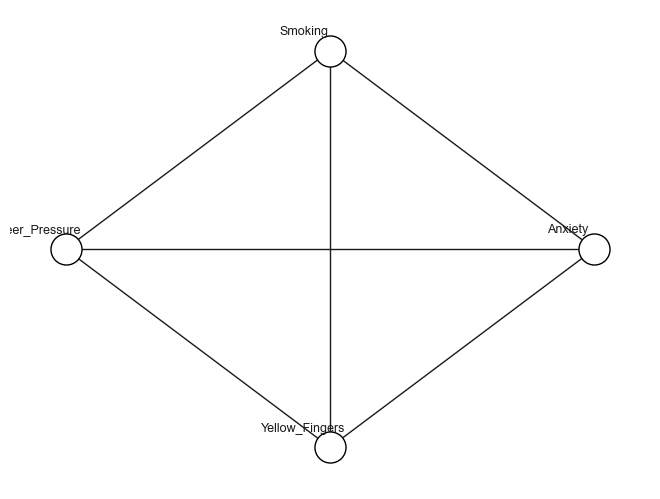

In [2]:
# import data
df_lucas0 = pd.read_csv("lucas0_train.csv")

# we import networkx and create a directed graph
G = nx.DiGraph()
G.add_nodes_from(['Anxiety', 'Smoking', 'Peer_Pressure', 'Yellow_Fingers'])
G.add_edges_from(
    [('Anxiety', 'Smoking'),
     ('Peer_Pressure', 'Smoking'),
     ('Smoking', 'Yellow_Fingers'),
     ('Peer_Pressure', 'Anxiety'),
     ('Smoking', 'Yellow_Fingers'),
     ('Anxiety', 'Yellow_Fingers'),
     ('Peer_Pressure', 'Yellow_Fingers'),
     ]
)
G = G.to_undirected()

pos = nx.kamada_kawai_layout(G)
pos_labels = plot_util.nudge(pos, -0.1, 0.1)
nx.draw(G, pos=pos, node_size=500, node_color='w', edgecolors='black')
nx.draw_networkx_labels(G, pos=pos_labels, font_size=9, font_weight=10)
nx.write_gml(G, "lucas0_backdoor_criterion_graph.gml")

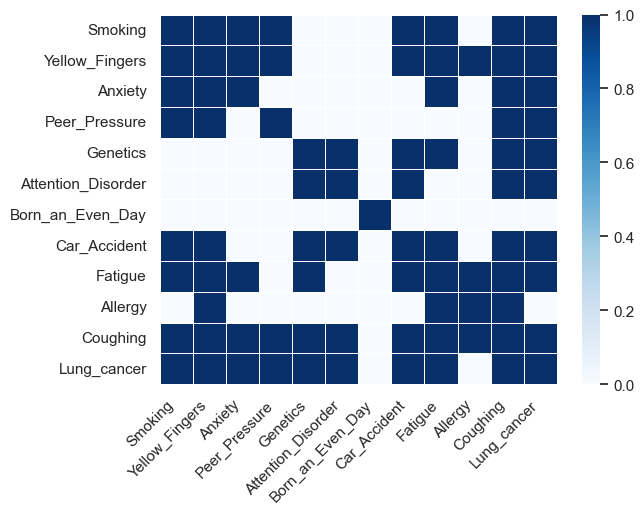

In [3]:
from lib.correlation import chi2_matrix

# compute chi2_independency_matrix
chi2_independency_matrix = chi2_matrix(df_lucas0, alpha=0.05)

# plot heatmap
feature_labels = df_lucas0.columns.values
target_feature_label = feature_labels[0]
explanatory_feature_labels = feature_labels[1:]
ax = sns.heatmap(chi2_independency_matrix, linewidth=0.5, yticklabels=feature_labels, cmap="Blues")
ax.set_xticklabels(feature_labels, rotation = 45, ha="right")
plt.show()

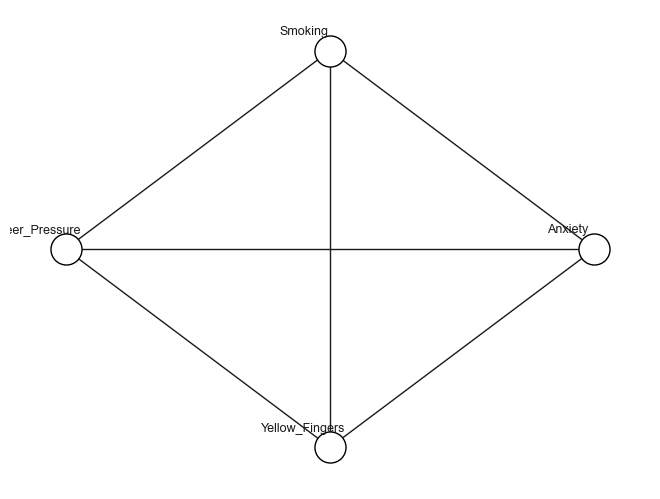

In [4]:
# import data
df_lucas0 = pd.read_csv("lucas0_train.csv")

# we import networkx and create a directed graph
G = nx.DiGraph()
G.add_nodes_from(['Anxiety', 'Smoking', 'Peer_Pressure', 'Yellow_Fingers'])
G.add_edges_from(
    [('Anxiety', 'Smoking'),
     ('Peer_Pressure', 'Smoking'),
     ('Smoking', 'Yellow_Fingers'),
     ('Smoking', 'Yellow_Fingers'),
     ('Anxiety', 'Yellow_Fingers'),
     ('Anxiety', 'Peer_Pressure'),
     ('Peer_Pressure', 'Yellow_Fingers'),
     ]
)
G = G.to_undirected()

pos = nx.kamada_kawai_layout(G)
pos_labels = plot_util.nudge(pos, -0.1, 0.1)
nx.draw(G, pos=pos, node_size=500, node_color='w', edgecolors='black')
nx.draw_networkx_labels(G, pos=pos_labels, font_size=9, font_weight=10)
nx.write_gml(G, "lucas0_backdoor_criterion_graph.gml")

{'Anxiety': Text(0.8999999959261293, 0.10000003032746417, 'Anxiety'),
 'Smoking': Text(-0.10000003712818678, 1.1, 'Smoking'),
 'Peer_Pressure': Text(-1.0999999912711036, 0.0999999568697673, 'Peer_Pressure'),
 'Yellow_Fingers': Text(-0.09999996752683908, -0.8999999871972314, 'Yellow_Fingers')}

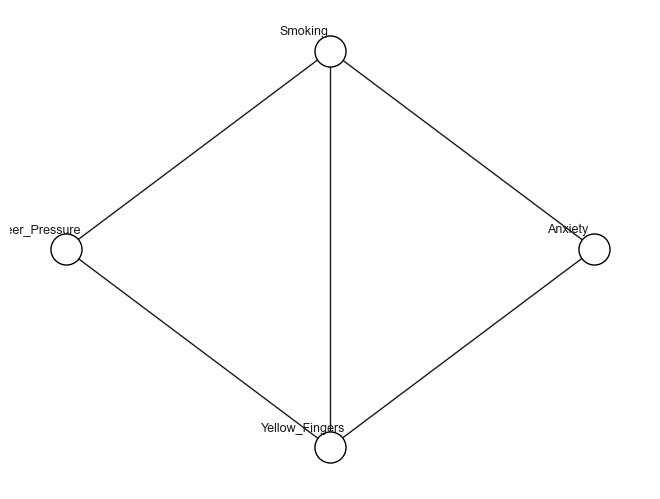

In [5]:
G.remove_edge('Anxiety', 'Peer_Pressure')
nx.draw(G, pos=pos, node_size=500, node_color='w', edgecolors='black')
nx.draw_networkx_labels(G, pos=pos_labels, font_size=9, font_weight=10)

In [6]:
# Anxiety _||_ Yellow_Fingers | Smoking
from lib.correlation import conditional_chi2_test
j = df_lucas0.columns.get_loc("Anxiety")
i = df_lucas0.columns.get_loc("Yellow_Fingers")
cond_set = [df_lucas0.columns.get_loc("Smoking")]
chi2, p = conditional_chi2_test(df_lucas0.values, i=i, j=j, cond_set=cond_set)
print(f"chi2 {chi2}")
print(f"p {p}")

chi2 0.0
p 1.0


In [7]:
# Anxiety _||_ Peer_Pressure | Smoking
from lib.correlation import conditional_chi2_test
j = df_lucas0.columns.get_loc("Anxiety")
i = df_lucas0.columns.get_loc("Peer_Pressure")
cond_set = [df_lucas0.columns.get_loc("Smoking")]
chi2, p = conditional_chi2_test(df_lucas0.values, i=i, j=j, cond_set=cond_set)
print(f"chi2 {chi2}")
print(f"p {p}")

chi2 0.8535664165425589
p 0.35554536980959095


In [8]:
# Yellow_Fingers _||_ Peer_Pressure | Smoking
from lib.correlation import conditional_chi2_test
j = df_lucas0.columns.get_loc("Peer_Pressure")
i = df_lucas0.columns.get_loc("Yellow_Fingers")
cond_set = [df_lucas0.columns.get_loc("Smoking")]
chi2, p = conditional_chi2_test(df_lucas0.values, i=i, j=j, cond_set=cond_set)
print(f"chi2 {chi2}")
print(f"p {p}")

chi2 0.0
p 1.0


In [9]:
#G.remove_edge('Anxiety', 'Peer_Pressure')
#nx.draw(G, pos=pos, node_size=500, node_color='w', edgecolors='black')
#nx.draw_networkx_labels(G, pos=pos_labels, font_size=9, font_weight=10)

# Full PC algorithm

**The full PC algorithm is available in the CausalDiscoveryTool (cdt) package**. The default CItest we use here is Gaussion CI test. There is also a list of options possible for different CI tests.
```CI_test = {'binary': "pcalg::binCItest", 
             'discrete': "pcalg::disCItest",
             'hsic_gamma': "kpcalg::kernelCItest",
             'hsic_perm': "kpcalg::kernelCItest",
             'hsic_clust': "kpcalg::kernelCItest",
             'gaussian': "pcalg::gaussCItest",
             'rcit': "RCIT:::CItest",
             'rcot': "RCIT:::CItest"}```

In [28]:
import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.1/bin/Rscript' # for Windows

{'Smoking': Text(0.14241128, 0.5722563, 'Smoking'),
 'Yellow_Fingers': Text(0.2394643052981418, -0.17614722073573383, 'Yellow_Fingers'),
 'Anxiety': Text(0.5406959660152065, 0.8985479710237975, 'Anxiety'),
 'Peer_Pressure': Text(0.33655651, 1.1, 'Peer_Pressure'),
 'Genetics': Text(-0.42439477999999997, 0.45175036, 'Genetics'),
 'Attention_Disorder': Text(-0.6646599, -0.07262073999999999, 'Attention_Disorder'),
 'Born_an_Even_Day': Text(0.8, -0.1, 'Born_an_Even_Day'),
 'Car_Accident': Text(-0.90340309, -0.59772843, 'Car_Accident'),
 'Fatigue': Text(-0.34034602999999997, -0.48207535, 'Fatigue'),
 'Allergy': Text(0.76673459, -0.5185142, 'Allergy'),
 'Coughing': Text(0.20659507000000002, -0.50125696, 'Coughing'),
 'Lung_cancer': Text(-0.037610460000000005, 0.02504297000000001, 'Lung_cancer')}

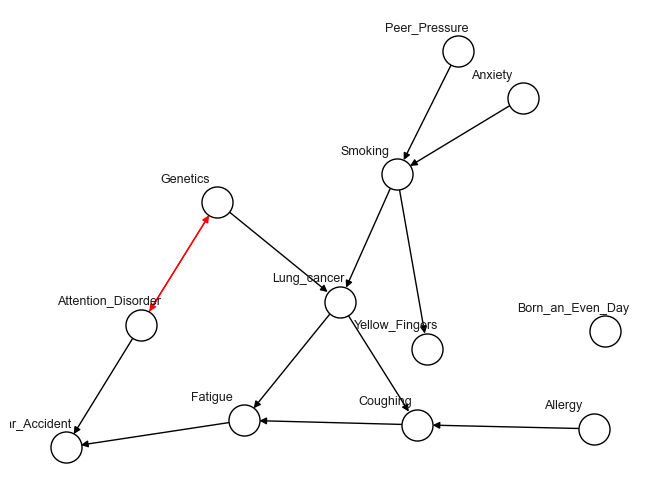

In [32]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.05)
pc_graph = pc.create_graph_from_data(df_lucas0)

'''
pos = nx.kamada_kawai_layout(pc_graph)
pos = {
    **pos,
    "Born_an_Even_Day": [0.9, -0.2],
    "Yellow_Fingers": [pos["Yellow_Fingers"][0] + 0.2, pos["Yellow_Fingers"][1] - 0.2],
    "Anxiety": [pos["Anxiety"][0] + 0.2, pos["Anxiety"][1] - 0.2],
}
'''

#Hardcoding node positions from Estimands to comapre graphs easily
pos = {'Smoking': np.array([0.24241128, 0.4722563 ]),
 'Yellow_Fingers': [0.3394643052981418, -0.27614722073573383],
 'Anxiety': [0.6406959660152065, 0.7985479710237975],
 'Peer_Pressure': np.array([0.43655651, 1.        ]),
 'Genetics': np.array([-0.32439478,  0.35175036]),
 'Attention_Disorder': np.array([-0.5646599 , -0.17262074]),
 'Born_an_Even_Day': [0.9, -0.2],
 'Car_Accident': np.array([-0.80340309, -0.69772843]),
 'Fatigue': np.array([-0.24034603, -0.58207535]),
 'Allergy': np.array([ 0.86673459, -0.6185142 ]),
 'Coughing': np.array([ 0.30659507, -0.60125696]),
 'Lung_cancer': np.array([ 0.06238954, -0.07495703])}

pos_labels = plot_util.nudge(pos, -0.1, 0.1)

colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=False, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)
nx.draw_networkx_labels(pc_graph, pos=pos_labels, font_size=9, font_weight=10)